# Data Science Fundamentals Project

Welcome to our data science project focused on predicting NO2 concentrations. We're using advanced analytics and machine learning to forecast NO2 levels based on a range of features, from meteorological conditions to human activities. Our goal is to contribute to environmental sustainability by developing a precise predictive model.

In [1]:
# Load all of the necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
import re
import numpy as np
import seaborn as sns

## Datasets
For our prediction, the following datasets are necessary:

- 1: Täglich aktualisierte Luftqualitätsmessungen, seit 1983
   - https://data.stadt-zuerich.ch/dataset/ugz_luftschadstoffmessung_tageswerte
- 2: Daten der Verkerzählung zum motorisierten Individualverkehr (Stundenwerte), seit 2012
   - https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031
- 3: Täglich aktualisierte Meteodaten, seit 1992
   - https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_tagesmittelwerte
- 4: Stündlich aktualisierte Meteodaten, seit 1992
   - https://data.stadt-zuerich.ch/dataset/ugz_meteodaten_stundenmittelwerte
- 5: Baumkataster
   - https://data.stadt-zuerich.ch/dataset/geo_baumkataster


We decided to make predictions on a daily basis, as to not be too granular with our prediction.

## Preprocessing
The first step was to merge all of the datasets to be able to predict NO2 well with the other columns. 

Dataset 1, that measures the airquality with different features, was also established by merging 12 datasets with numbers from 2012 to 2023.

Dataset 2, that counts the passing cars, was established by merging the 12 individual datasets that include the data from 2012 to 2023.

Dataset 3, <span style="color:red">[INSERT DESCRIPTION]</span>

Dataset 4, <span style="color:red">[INSERT DESCRIPTION]</span>

### Functions used for Preprocessing
- We created the function "import_and_transform_air_quality_data()" to loop over all of the years from 2012 to 2023 and merge all of the datasets while only taking into consideration the streets of interest, namely "Rosengartenstrasse", "Stampfenbachstrasse" and "Schimmelstrasse". We decided to only inspect these streets because <span style="color:red">[INSERT REASON]</span>

In [2]:
def import_and_transform_air_quality_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/air/ugz_ogd_air_d1_{year}.csv'
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert')

            # Add the year and street columns
            street_wide['Year'] = year
            street_wide['Street'] = street

            yearly_data.append(street_wide)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


The cell below saves the 12 airquality datasets into one big dataset

In [3]:
airquality = import_and_transform_air_quality_data()

- Another function we created is "import_and_transform_traffic_data()", which handles the preprocessing for datset 2 in a similar fashion as the function above.

In [4]:
def import_and_transform_traffic_data():
    streets = ['Stampfenbachstrasse (Wasserwerkstrasse)', 'Schimmelstrasse (Werdstrasse)', 'Rosengartenstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/traffic/sid_dav_verkehrszaehlung_miv_OD2031_{year}.csv'
            traffic = pd.read_csv(file_path)

            # Drop unnecessary columns and filter for a specific street
            traffic_small = traffic.drop(columns=['MSID', 'MSName', 'Hoehe', 'EKoord', 'NKoord', 'AnzDetektoren', 'D1ID', 'D2ID', 'D3ID','D4ID', 'Knummer', 'ZSID'])
            traffic_rg = traffic_small[traffic_small['ZSName'] == street]

            # Convert 'MessungDatZeit' column to datetime
            try:
                traffic_rg['MessungDatZeit'] = pd.to_datetime(traffic_rg['MessungDatZeit'])
            except pd.errors.OutOfBoundsDatetime:
                # Handle conversion errors, for example, if the data contains unexpected values
                print(f"Error converting 'MessungDatZeit' column for year {year} and street {street}")

            # Aggregate data
            daily_traffic = traffic_rg.groupby(traffic_rg['MessungDatZeit'].dt.date)['AnzFahrzeuge'].sum().reset_index(name='TotalDailyTraffic')
            daily_traffic['Year'] = year
            daily_traffic['Street'] = street

            yearly_data.append(daily_traffic)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


The cell below saves the 12 traffic datasets into one big dataset

In [5]:
traffic = import_and_transform_traffic_data()

/var/folders/7l/qv8kt1r500sd24bjm0km535r0000gn/T/ipykernel_2786/1852869754.py:10: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic = pd.read_csv(file_path)
/var/folders/7l/qv8kt1r500sd24bjm0km535r0000gn/T/ipykernel_2786/1852869754.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_rg['MessungDatZeit'] = pd.to_datetime(traffic_rg['MessungDatZeit'])
/var/folders/7l/qv8kt1r500sd24bjm0km535r0000gn/T/ipykernel_2786/1852869754.py:10: DtypeWarning: Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.
  traffic = pd.read_csv(file_path)
/var/folders/7l/qv8kt1r500sd24bjm0km535r0000gn/T/ipykernel_2786/1852869754.py:18: SettingWithCopyWarning: 
A val

Now, we have two big datasets with all of the relevant data from years 2012 to 2023. To be able to merge them we do the steps in the cell below.

In [6]:
#Introduce an Index for both df
airquality = airquality.reset_index()
traffic = traffic.reset_index()
# Convert the 'Datum' column in air quality data to datetime and extract the date
airquality['Datum'] = pd.to_datetime(airquality['Datum']).dt.date

# Replace street names in traffic data to match the air quality data
traffic.replace(['Stampfenbachstrasse (Wasserwerkstrasse)', 'Schimmelstrasse (Werdstrasse)', 'Rosengartenstrasse'],
                ['Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse', 'Zch_Rosengartenstrasse'], inplace=True)

# Rename the 'MessungDatZeit' column in traffic data to 'Datum'
traffic.rename(columns={'MessungDatZeit': 'Datum'}, inplace=True)

#### Merging of the two datasets

In [7]:
merged_df = pd.merge(traffic, airquality, how="left", on=['Datum', 'Street'])
merged_df.drop(columns=['Year_x', 'Year_y'], inplace=True)

### Additional Features: Meteo Data
Now that we have many of the necessary features inside of one dataset, we want to add some more that could make our prediction model more accurate. For that we turned to meteo data, which is dataset 3.






In [8]:
def import_and_transform_meteo_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []

    for street in streets:
        yearly_data = []

        for year in range(2012, 2024):
            file_path = f'data/meteo/daily/ugz_ogd_meteo_d1_{year}.csv'
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data and reset the index
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert').reset_index()

            # Add the year and street columns
            street_wide['Year'] = year
            street_wide['Street'] = street

            yearly_data.append(street_wide)

        # Concatenate all years' data for the street
        combined_street_data = pd.concat(yearly_data)
        street_dataframes.append(combined_street_data)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes)

    return combined_data


In [9]:
meteo = import_and_transform_meteo_data()
meteo['Datum'] = pd.to_datetime(meteo['Datum']).dt.date
meteo.head()

Parameter       Datum  Year                  Street  RainDur   T  T_max_h1  \
0          2013-10-04  2013  Zch_Rosengartenstrasse   191.77 NaN       NaN   
1          2013-10-05  2013  Zch_Rosengartenstrasse    84.13 NaN       NaN   
2          2013-10-06  2013  Zch_Rosengartenstrasse   147.52 NaN       NaN   
3          2013-10-07  2013  Zch_Rosengartenstrasse     0.00 NaN       NaN   
4          2013-10-08  2013  Zch_Rosengartenstrasse     0.00 NaN       NaN   

Parameter       p  StrGlo  
0          969.68     NaN  
1          968.27     NaN  
2          973.08     NaN  
3          973.86     NaN  
4          973.71     NaN

The cell below merges the merged dataframe and the meteo dataframe.

In [10]:

# Merge DataFrames
merged_meteo = pd.merge(merged_df, meteo, how="left", on=['Datum', 'Street'])


windspeed and humidity data is only found in the hourly meteo set, so we will sum it up to daily values and add it 

In [11]:
def import_and_transform_meteo_hourly_data():
    streets = ['Zch_Rosengartenstrasse', 'Zch_Stampfenbachstrasse', 'Zch_Schimmelstrasse']
    street_dataframes = []
    parameters = ['WD', 'WVv', 'WVs', 'Hr']

    for year in range(2012, 2024): 
        for street in streets:
            file_path = f'data/meteo/hourly/ugz_ogd_meteo_h1_{year}.csv'  
            data = pd.read_csv(file_path)

            # Filter for a specific street
            street_data = data[data['Standort'] == street]

            # Pivot the data to wide format
            street_wide = street_data.pivot(index='Datum', columns='Parameter', values='Wert')

            # Reset index to make 'Datum' a column again
            street_wide.reset_index(inplace=True)

            # Convert 'Datum' to datetime and keep only the date part
            street_wide['Datum'] = pd.to_datetime(street_wide['Datum']).dt.date

            # Select only the columns that exist in the dataset
            cols_to_keep = ['Datum'] + [col for col in parameters if col in street_wide.columns]
            street_wide = street_wide[cols_to_keep]

            # Group by Datum, calculate daily mean
            daily_mean = street_wide.groupby('Datum', as_index=False).mean()

            # Add the street name to the DataFrame
            daily_mean['Street'] = street

            street_dataframes.append(daily_mean)

    # Concatenate all streets' data into one DataFrame
    combined_data = pd.concat(street_dataframes, ignore_index=True)

    return combined_data

# Use this function and export the result if needed
meteo_hourly = import_and_transform_meteo_hourly_data()
#merge it

merged_meteo = pd.merge(merged_meteo, meteo_hourly, how="left", on=['Datum', 'Street'])

### Additional Features: Dummies

Now, we will create some dummy variables out of the Date column


In [12]:
# Convert 'Datum' to datetime
merged_meteo['Datum'] = pd.to_datetime(merged_meteo['Datum'])

# Drop unnecessary columns
merged_meteo.drop(columns=['Year'], inplace=True)

# Adding season dummies
#def get_month(date):
   # month_dict = {
        #1: 'Jan',
        #2: 'Feb',
        #3: 'Mar',
        #4: 'Apr',
       # 5: 'May',
       # 6: 'Jun',
       # 7: 'Jul',
       # 8: 'Aug',
       # 9: 'Sep',
       # 10: 'Oct',
       # 11: 'Nov',
       # 12: 'Dec'
   # }
    #return month_dict[date.month]

#merged_meteo['Month'] = merged_meteo['Datum'].apply(get_month)
#month_dummies = pd.get_dummies(merged_meteo['Month'])
#merged_meteo = pd.concat([merged_meteo, month_dummies], axis=1).drop(columns=['Month'])

merged_meteo['Season'] = (merged_meteo['Datum'].dt.month % 12 + 3) // 3
season_dummies = pd.get_dummies(merged_meteo['Season'], prefix='Season')
merged_meteo = pd.concat([merged_meteo, season_dummies], axis=1).drop(columns=['Season'])

# Adding weekday dummies
merged_meteo['Weekday'] = merged_meteo['Datum'].dt.dayofweek
weekday_dummies = pd.get_dummies(merged_meteo['Weekday'], prefix='Weekday')
merged_meteo = pd.concat([merged_meteo, weekday_dummies], axis=1)
merged_meteo.drop(['Weekday'], axis=1, inplace=True)

### Additional Features: Relevant Street Specific Data

As we want to generalize our model to be applicable to other streets, we tried to find data which is relevant for the specific street.

The only data we found: Data on Trees and Greenspaces (coordinates).

We used this to calculate the trees/greenspaces around our measurement points

In [13]:
#calculating trees around measurement points

tree_locations_df = pd.read_csv('data/street/gsz.baumkataster_baumstandorte.csv')

def extract_coordinates(point_str):
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", point_str)
    return tuple(map(float, numbers))

tree_locations_df['coordinates'] = tree_locations_df['geometry'].apply(extract_coordinates)

def calculate_distance(coord1, coord2):
    return ((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2) ** 0.5

target_coords = {
    "Zch_Rosengartenstrasse": (2682095, 1249940),
    "Zch_Schimmelstrasse": (2681950, 1247250),
    "Zch_Stampfenbachstrasse": (2683140, 1249040)
}

tree_counts_df = pd.DataFrame(columns=['Street', '1.5km', '1km', '500m', '200m'])

for street, coords in target_coords.items():
    tree_counts = {
        'Street': street,
        '1.5km': sum(calculate_distance(tree_coord, coords) <= 1500 for tree_coord in tree_locations_df['coordinates']),
        '1km': sum(calculate_distance(tree_coord, coords) <= 1000 for tree_coord in tree_locations_df['coordinates']),
        '500m': sum(calculate_distance(tree_coord, coords) <= 500 for tree_coord in tree_locations_df['coordinates']),
        '200m': sum(calculate_distance(tree_coord, coords) <= 200 for tree_coord in tree_locations_df['coordinates'])
    }
    tree_counts_df = pd.concat([tree_counts_df, pd.DataFrame([tree_counts])], ignore_index=True)


# calculating green spaces around measurement points

green_spaces_df = pd.read_csv('data/street/gsz.gruenflaechen.csv')

green_spaces_df['coordinates'] = green_spaces_df['geometry'].apply(extract_coordinates)

green_space_counts_df = pd.DataFrame(columns=['Street', '1.5km', '1km', '500m', '200m'])

for street, coords in target_coords.items():
    green_space_counts = {
        'Street': street,
        '1.5km': sum(calculate_distance(green_coord, coords) <= 1500 for green_coord in green_spaces_df['coordinates']),
        '1km': sum(calculate_distance(green_coord, coords) <= 1000 for green_coord in green_spaces_df['coordinates']),
        '500m': sum(calculate_distance(green_coord, coords) <= 500 for green_coord in green_spaces_df['coordinates']),
        '200m': sum(calculate_distance(green_coord, coords) <= 200 for green_coord in green_spaces_df['coordinates'])
    }
    green_space_counts_df = pd.concat([green_space_counts_df, pd.DataFrame([green_space_counts])], ignore_index=True)


In [14]:
#merging it with the data set

merged_meteo = pd.merge(merged_meteo, green_space_counts_df, on='Street', how='left', suffixes=('_green', ''))
merged_meteo = pd.merge(merged_meteo, tree_counts_df, on='Street', how='left', suffixes=('','_trees'))
distance_columns_to_rename = {
    '1.5km': '1.5km_green',
    '1km': '1km_green',
    '500m': '500m_green',
    '200m': '200m_green'
}
merged_meteo = merged_meteo.rename(columns=distance_columns_to_rename)
merged_meteo.columns

Index(['index', 'Datum', 'TotalDailyTraffic', 'Street', 'NO', 'NO2', 'NOx',
       'O3', 'O3_max_h1', 'O3_nb_h1>120', 'PM10', 'PM2.5', 'CO', 'SO2', 'PN',
       'RainDur', 'T', 'T_max_h1', 'p', 'StrGlo', 'WD', 'WVv', 'WVs', 'Hr',
       'Season_1', 'Season_2', 'Season_3', 'Season_4', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', '1.5km_green', '1km_green', '500m_green', '200m_green',
       '1.5km_trees', '1km_trees', '500m_trees', '200m_trees'],
      dtype='object')

### Target Variable NO2_tomorrow

We create the target variable by shifting up the NO2 column by one row. 
We do this for each street seperately. And then merge it again


In [15]:
# Create the NO2_tomorrow (target variable) column by shifting the NO2 column up by one row
unique_streets = merged_meteo['Street'].unique()
data_separated = []
for street in unique_streets:
    df_street = merged_meteo[merged_meteo['Street'] == street].copy()
    df_street['NO2_tomorrow'] = df_street['NO2'].shift(-1)
    data_separated.append(df_street)

merged_meteo = pd.concat(data_separated)

merged_meteo


index      Datum  TotalDailyTraffic                   Street     NO  \
0          0 2012-01-01             8118.0  Zch_Stampfenbachstrasse   7.83   
1          1 2012-01-02             7537.0  Zch_Stampfenbachstrasse   3.51   
2          2 2012-01-03            11722.0  Zch_Stampfenbachstrasse   5.85   
3          3 2012-01-04            12161.0  Zch_Stampfenbachstrasse   2.59   
4          4 2012-01-05            12310.0  Zch_Stampfenbachstrasse   2.23   
...      ...        ...                ...                      ...    ...   
13024    324 2023-11-21            24188.0   Zch_Rosengartenstrasse  23.29   
13025    325 2023-11-22            25017.0   Zch_Rosengartenstrasse  19.41   
13026    326 2023-11-23            24714.0   Zch_Rosengartenstrasse  30.60   
13027    327 2023-11-24            25337.0   Zch_Rosengartenstrasse  22.50   
13028    328 2023-11-25            22228.0   Zch_Rosengartenstrasse  15.81   

         NO2    NOx     O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  \
0      26.54  20.16  22.24      43.46           0.0  ...       True   
1      17.87  12.16  36.06      53.56           0.0  ...      False   
2      19.62  14.95  48.88      66.05           0.0  ...      False   
3      13.25   9.00  59.47      67.55           0.0  ...      False   
4      10.11   7.08  62.58      71.45           0.0  ...      False   
...      ...    ...    ...        ...           ...  ...        ...   
13024  35.09  37.02  27.96      57.38           0.0  ...      False   
13025  22.47  27.31  23.17      33.90           0.0  ...      False   
13026  30.86  40.67  10.30      21.01           0.0  ...      False   
13027  29.74  33.59  33.94      54.68           0.0  ...      False   
13028  24.91  25.70  39.99      51.06           0.0  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
0             7471       4473        1611         132         9115       4054   
1             7471       4473        1611         132         9115       4054   
2             7471       4473        1611         132         9115       4054   
3             7471       4473        1611         132         9115       4054   
4             7471       4473        1611         132         9115       4054   
...            ...        ...         ...         ...          ...        ...   
13024         8289       3424        1271         219         9730       3376   
13025         8289       3424        1271         219         9730       3376   
13026         8289       3424        1271         219         9730       3376   
13027         8289       3424        1271         219         9730       3376   
13028         8289       3424        1271         219         9730       3376   

       500m_trees  200m_trees  NO2_tomorrow  
0            1419         152         17.87  
1            1419         152         19.62  
2            1419         152         13.25  
3            1419         152         10.11  
4            1419         152         17.67  
...           ...         ...           ...  
13024         918         179         22.47  
13025         918         179         30.86  
13026         918         179         29.74  
13027         918         179         24.91  
13028         918         179           NaN  

[13029 rows x 44 columns]

### Seasonality Considerations

We have already added dummy variables for season and weekday. However, it might make sense to remove seasonality. Let's see what we observe:

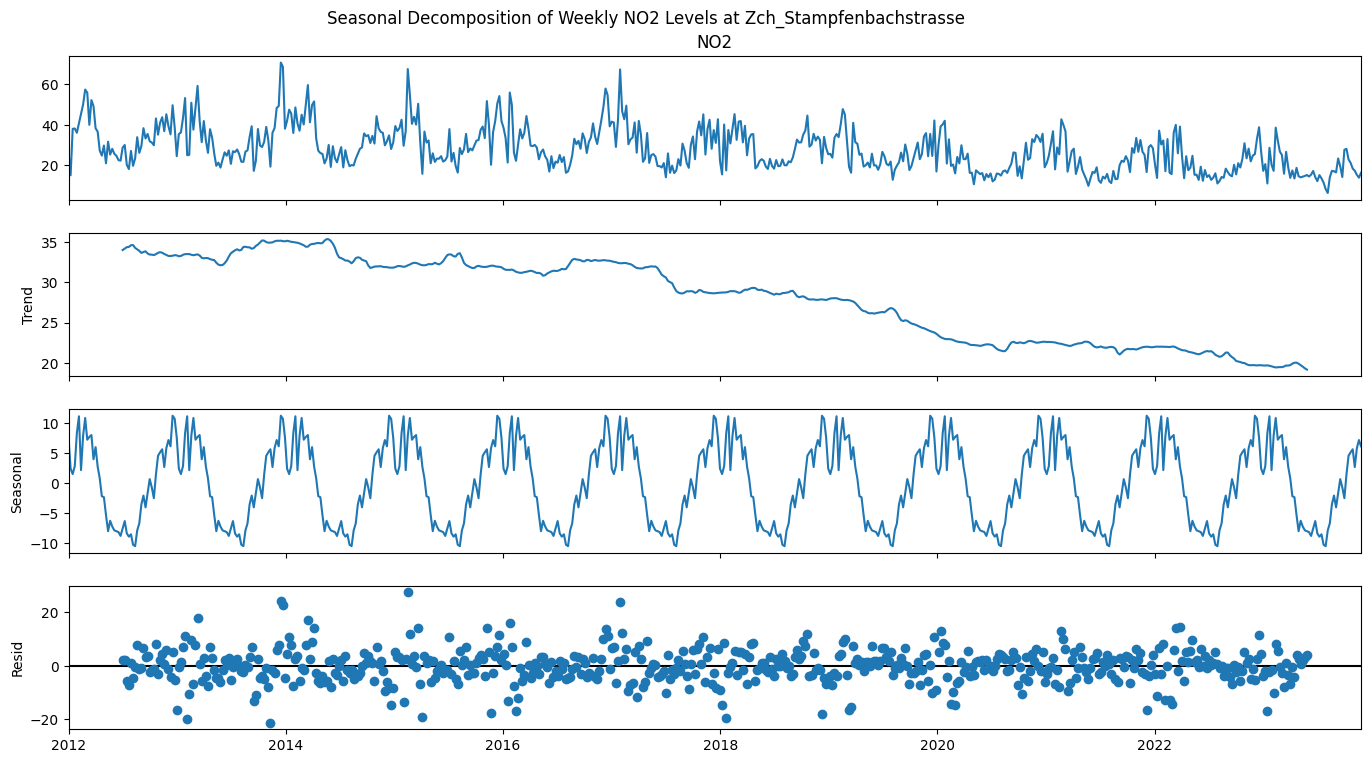

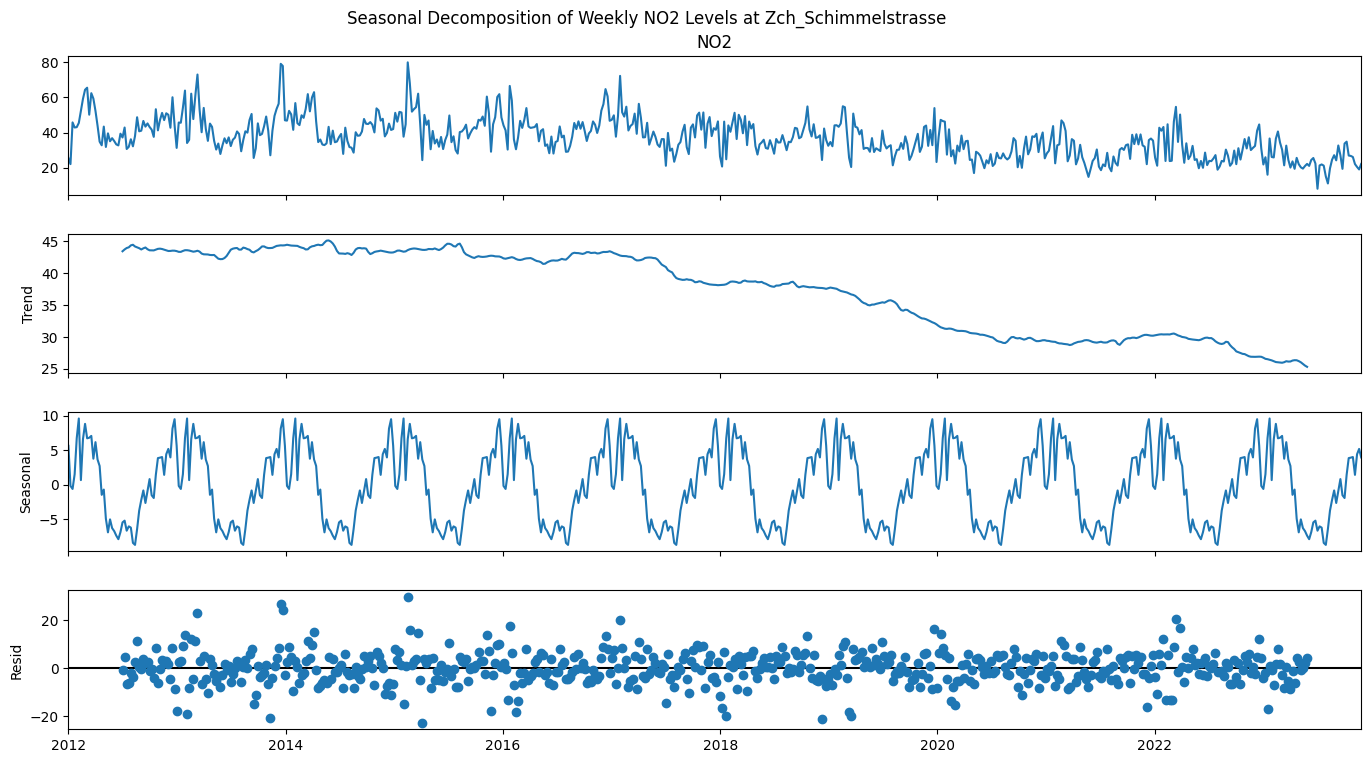

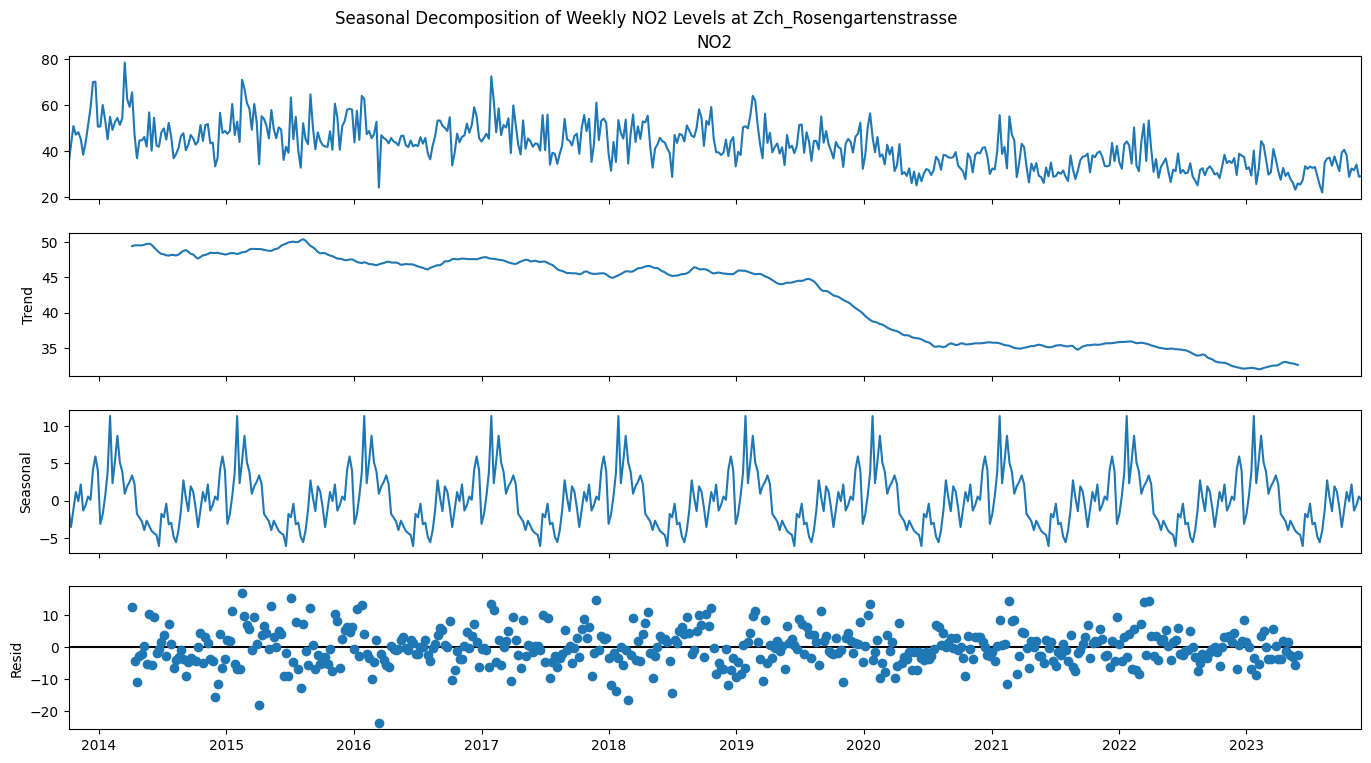

In [16]:

from statsmodels.tsa.seasonal import seasonal_decompose

unique_streets = merged_meteo['Street'].unique()

# Iterating through each street and performing seasonal decomposition
for street in unique_streets:
    # Filtering data for the current street
    street_data = merged_meteo[merged_meteo['Street'] == street]

    # Aggregating NO2 levels to weekly average
    street_data.set_index('Datum', inplace=True)
    weekly_street_data = street_data['NO2'].resample('W').mean()

    # Perform seasonal decomposition if there are enough data points
    if not weekly_street_data.isnull().all():
        decomposition = seasonal_decompose(weekly_street_data.dropna(), model='additive', period=52)

        # Plotting the decomposed components of the time series
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)
        plt.suptitle(f'Seasonal Decomposition of Weekly NO2 Levels at {street}')
        plt.show()
    else:
        print(f"No NO2 values are available for {street} in the dataset.")


We see strong seasonality over all three streets. However, as we work with NO2 as a feature, which has a time-lag of only one day, this seasonality is already incorporated in our model. 

We also see a downward trend in our target variable. This is also incorporated in our NO2 feature.

### Splitting Training and Test Set

We want to use the 2023 data as a test set for our model. However, for imuting, we sue the same tactics for both train and test set

In [17]:
# Filtering the dataset for the test set (year 2023)
test_set = merged_meteo[merged_meteo['Datum'].dt.year == 2023]

# Filtering the dataset for the train set (years other than 2023)
train_set = merged_meteo[merged_meteo['Datum'].dt.year != 2023]


In [18]:
#For our test set we simply drop all rows with NaNs

#test_set_cleaned = test_set.dropna()

#### (Train Set) --> imputing both

In [19]:
# Checking for missing values in the target variable 'NO2_tomorrow'

missing_values_target = train_set['NO2_tomorrow'].isnull().sum() #revealed around 700 missing values, we will delete these rows
train_set = train_set.dropna(subset=['NO2_tomorrow'])
test_set = test_set.dropna(subset=['NO2_tomorrow'])

In [20]:
# Checking for columns with a high percentage of missing values

missing_values = train_set.isnull().sum()
missing_values_percentage = (missing_values / len(train_set)) * 100

#columns with more than 10% missing values
columns_high_missing_values = missing_values_percentage[missing_values_percentage > 10].sort_values(ascending=False)

columns_high_missing_values

SO2       64.723006
StrGlo    64.670078
CO        64.643613
PN        49.523641
PM2.5     46.788991
WVs       35.471066
dtype: float64

In [21]:
# we will drop these above (and just below) 50% for sure 

columns_to_drop = ['SO2', 'StrGlo', 'CO', 'PN', 'PM2.5']
train_set = train_set.drop(columns=columns_to_drop)
test_set = test_set.drop(columns=columns_to_drop)


The rest we cannot just drop. We will look at these in more details to find a way to impute them

In [22]:
# Count NaNs for all columns
missing_count_per_column = train_set.isna().sum()

# Filter columns with missing values
columns_with_missing_values = missing_count_per_column[missing_count_per_column > 0]

# Display the count of missing values for columns with missing values
print(columns_with_missing_values)


NO                24
NO2               24
NOx               24
O3                90
O3_max_h1         94
O3_nb_h1>120      94
PM10             269
RainDur           25
T                 80
T_max_h1          84
p                 35
WD               598
WVv              598
WVs             4021
Hr               123
dtype: int64


We observe that there are a total of 15 columns that contain missing values.
We plot a histogram and boxplot of each of the 15 columns to observe the distribution of the data.

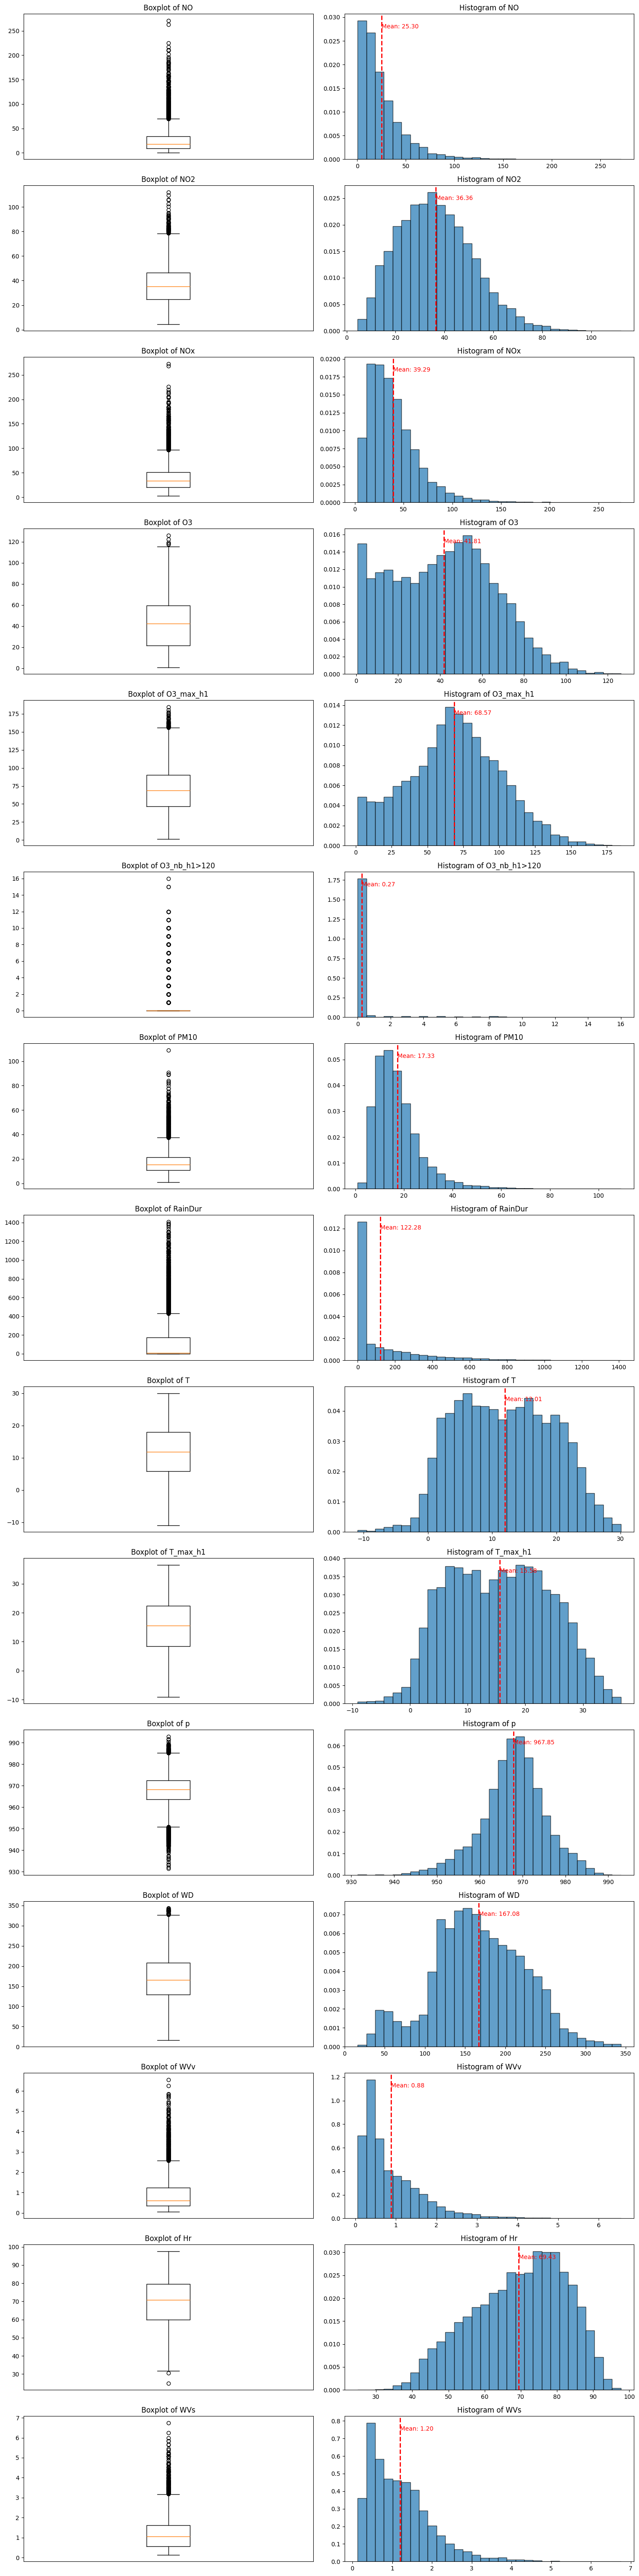

In [23]:
columns_with_missing_values = [
    "NO", "NO2", "NOx", "O3", "O3_max_h1", "O3_nb_h1>120", "PM10",
    "RainDur", "T", "T_max_h1", "p", "WD", "WVv", "Hr", 'WVs'
]

fig, axes = plt.subplots(nrows=len(columns_with_missing_values), ncols=2, figsize=(15, 4 * len(columns_with_missing_values)))

for i, column_name in enumerate(columns_with_missing_values):
    # Select the right axes for boxplot and histogram
    ax_box = axes[i, 0]
    ax_hist = axes[i, 1]

    # Drop NaN values from the column
    column_data = train_set[column_name].dropna()

    # Boxplot
    ax_box.boxplot(column_data)
    ax_box.set_title(f'Boxplot of {column_name}')
    ax_box.set_xticks([])

    # Histogram
    bin_count = 30  # Increased number of bins for more detail
    ax_hist.hist(column_data, bins=bin_count, edgecolor='black', alpha=0.7, density=True)
    ax_hist.set_title(f'Histogram of {column_name}')

    # Calculate and plot the mean
    mean = column_data.mean()
    ax_hist.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    ax_hist.text(mean, ax_hist.get_ylim()[1] * 0.9, f'Mean: {mean:.2f}', color='red')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

For rows with a lot of NaN's, regular imputation might not make sense (we would have a lot of similar rows then). Let's find these

In [24]:
# Finding rows with multiple NaN values
rows_with_multiple_nans_train = train_set[train_set.isna().sum(axis=1) > 10]
rows_with_multiple_nans_test = test_set[test_set.isna().sum(axis=1) > 10]

# Identifying the names of features missing in rows with multiple NaNs
missing_features_train = rows_with_multiple_nans_train.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_train_df = missing_features_train.to_frame(name="Missing Features")
missing_features_test = rows_with_multiple_nans_test.isna().apply(lambda x: list(x[x].index), axis=1)
missing_features_test_df = missing_features_test.to_frame(name="Missing Features")

In [25]:
row_indices_train = missing_features_train.index
row_indices_test = missing_features_test.index
selected_rows_train = train_set.loc[row_indices_train]
selected_rows_test = test_set.loc[row_indices_test]

selected_rows_train

index      Datum  TotalDailyTraffic                   Street  NO  NO2  \
1824     363 2016-12-29                0.0  Zch_Stampfenbachstrasse NaN  NaN   
2993      71 2020-03-12            13491.0  Zch_Stampfenbachstrasse NaN  NaN   
5587     148 2015-05-29            27654.0      Zch_Schimmelstrasse NaN  NaN   
5724     285 2015-10-13            27565.0      Zch_Schimmelstrasse NaN  NaN   
6636     101 2018-04-12            30103.0      Zch_Schimmelstrasse NaN  NaN   
7254     354 2019-12-21            27330.0      Zch_Schimmelstrasse NaN  NaN   
7288      23 2020-01-24            31233.0      Zch_Schimmelstrasse NaN  NaN   
7312      47 2020-02-17            27271.0      Zch_Schimmelstrasse NaN  NaN   
7607     342 2020-12-08            27947.0      Zch_Schimmelstrasse NaN  NaN   
7928     297 2021-10-25            30743.0      Zch_Schimmelstrasse NaN  NaN   
7962     331 2021-11-28            28710.0      Zch_Schimmelstrasse NaN  NaN   
9327     275 2013-10-03            24281.0   Zch_Rosengartenstrasse NaN  NaN   
9962     180 2015-06-30                0.0   Zch_Rosengartenstrasse NaN  NaN   
10217     70 2016-03-11            26543.0   Zch_Rosengartenstrasse NaN  NaN   
10358    211 2016-07-30            16131.0   Zch_Rosengartenstrasse NaN  NaN   
11189    311 2018-11-08            27149.0   Zch_Rosengartenstrasse NaN  NaN   
12194    220 2021-08-09            21690.0   Zch_Rosengartenstrasse NaN  NaN   
12224    250 2021-09-08            26434.0   Zch_Rosengartenstrasse NaN  NaN   
12606    269 2022-09-27            27706.0   Zch_Rosengartenstrasse NaN  NaN   
12684    347 2022-12-14            26581.0   Zch_Rosengartenstrasse NaN  NaN   

       NOx  O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  1.5km_green  \
1824   NaN NaN        NaN           NaN  ...      False         7471   
2993   NaN NaN        NaN           NaN  ...      False         7471   
5587   NaN NaN        NaN           NaN  ...      False         8273   
5724   NaN NaN        NaN           NaN  ...      False         8273   
6636   NaN NaN        NaN           NaN  ...      False         8273   
7254   NaN NaN        NaN           NaN  ...      False         8273   
7288   NaN NaN        NaN           NaN  ...      False         8273   
7312   NaN NaN        NaN           NaN  ...      False         8273   
7607   NaN NaN        NaN           NaN  ...      False         8273   
7928   NaN NaN        NaN           NaN  ...      False         8273   
7962   NaN NaN        NaN           NaN  ...       True         8273   
9327   NaN NaN        NaN           NaN  ...      False         8289   
9962   NaN NaN        NaN           NaN  ...      False         8289   
10217  NaN NaN        NaN           NaN  ...      False         8289   
10358  NaN NaN        NaN           NaN  ...      False         8289   
11189  NaN NaN        NaN           NaN  ...      False         8289   
12194  NaN NaN        NaN           NaN  ...      False         8289   
12224  NaN NaN        NaN           NaN  ...      False         8289   
12606  NaN NaN        NaN           NaN  ...      False         8289   
12684  NaN NaN        NaN           NaN  ...      False         8289   

       1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
1824        4473        1611         132         9115       4054        1419   
2993        4473        1611         132         9115       4054        1419   
5587        3779         901         140        10143       4389        1138   
5724        3779         901         140        10143       4389        1138   
6636        3779         901         140        10143       4389        1138   
7254        3779         901         140        10143       4389        1138   
7288        3779         901         140        10143       4389        1138   
7312        3779         901         140        10143       4389        1138   
7607        3779         901         140        10143       4389        1138   
7928        3

In [26]:
selected_rows_test

index      Datum  TotalDailyTraffic                  Street  NO  NO2  \
8400      43 2023-02-13            33108.0     Zch_Schimmelstrasse NaN  NaN   
8537     180 2023-06-30            32896.0     Zch_Schimmelstrasse NaN  NaN   
8587     230 2023-08-19            40371.0     Zch_Schimmelstrasse NaN  NaN   
8654     297 2023-10-25            34270.0     Zch_Schimmelstrasse NaN  NaN   
12991    291 2023-10-19            23449.0  Zch_Rosengartenstrasse NaN  NaN   

       NOx  O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  1.5km_green  \
8400   NaN NaN        NaN           NaN  ...      False         8273   
8537   NaN NaN        NaN           NaN  ...      False         8273   
8587   NaN NaN        NaN           NaN  ...      False         8273   
8654   NaN NaN        NaN           NaN  ...      False         8273   
12991  NaN NaN        NaN           NaN  ...      False         8289   

       1km_green  500m_green  200m_green  1.5km_trees  1km_trees  500m_trees  \
8400        3779         901         140        10143       4389        1138   
8537        3779         901         140        10143       4389        1138   
8587        3779         901         140        10143       4389        1138   
8654        3779         901         140        10143       4389        1138   
12991       3424        1271         219         9730       3376         918   

       200m_trees  NO2_tomorrow  
8400          124         44.38  
8537          124          7.86  
8587          124         27.41  
8654          124         23.48  
12991         179         32.96  

[5 rows x 39 columns]

We find that there are 20 rows in the train set and 5 rows in the test set where all meteo data is missing. In order to impute those values, we take the average of the respective meteo data from the day before and the next day. We see that the rows are not at the end/beginning of a specific street, hence we know that the previous/next column will correspond to yesterday's/tomorrow's values.

In [27]:
# Function to get value if index exists, else None
def get_value_if_exists(df, idx, column):
    if idx in df.index:
        return df.loc[idx, column]
    return None

# Impute missing values for train set
for idx in missing_features_train_df.index:
    for column in missing_features_train_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(train_set, idx - 1, column) or get_value_if_exists(train_set, idx - 2, column)
        next_day_value = get_value_if_exists(train_set, idx + 1, column) or get_value_if_exists(train_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            train_set.loc[idx, column] = mean_value

# Impute missing values for test set
for idx in missing_features_test_df.index:
    for column in missing_features_test_df.loc[idx, "Missing Features"]:
        prev_day_value = get_value_if_exists(test_set, idx - 1, column) or get_value_if_exists(test_set, idx - 2, column)
        next_day_value = get_value_if_exists(test_set, idx + 1, column) or get_value_if_exists(test_set, idx + 2, column)

        if pd.notna(prev_day_value) and pd.notna(next_day_value):
            mean_value = (prev_day_value + next_day_value) / 2
            test_set.loc[idx, column] = mean_value

# The df DataFrame now has imputed values
selected_rows_train = train_set.loc[row_indices_train]
selected_rows_train

index      Datum  TotalDailyTraffic                   Street      NO  \
1824     363 2016-12-29                0.0  Zch_Stampfenbachstrasse  23.195   
2993      71 2020-03-12            13491.0  Zch_Stampfenbachstrasse   3.715   
5587     148 2015-05-29            27654.0      Zch_Schimmelstrasse     NaN   
5724     285 2015-10-13            27565.0      Zch_Schimmelstrasse     NaN   
6636     101 2018-04-12            30103.0      Zch_Schimmelstrasse     NaN   
7254     354 2019-12-21            27330.0      Zch_Schimmelstrasse     NaN   
7288      23 2020-01-24            31233.0      Zch_Schimmelstrasse     NaN   
7312      47 2020-02-17            27271.0      Zch_Schimmelstrasse     NaN   
7607     342 2020-12-08            27947.0      Zch_Schimmelstrasse     NaN   
7928     297 2021-10-25            30743.0      Zch_Schimmelstrasse     NaN   
7962     331 2021-11-28            28710.0      Zch_Schimmelstrasse     NaN   
9327     275 2013-10-03            24281.0   Zch_Rosengartenstrasse     NaN   
9962     180 2015-06-30                0.0   Zch_Rosengartenstrasse     NaN   
10217     70 2016-03-11            26543.0   Zch_Rosengartenstrasse     NaN   
10358    211 2016-07-30            16131.0   Zch_Rosengartenstrasse     NaN   
11189    311 2018-11-08            27149.0   Zch_Rosengartenstrasse     NaN   
12194    220 2021-08-09            21690.0   Zch_Rosengartenstrasse  17.065   
12224    250 2021-09-08            26434.0   Zch_Rosengartenstrasse     NaN   
12606    269 2022-09-27            27706.0   Zch_Rosengartenstrasse  19.210   
12684    347 2022-12-14            26581.0   Zch_Rosengartenstrasse     NaN   

          NO2     NOx      O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  \
1824   45.050  42.160  10.340     20.635           0.0  ...      False   
2993   18.410  12.610  59.080     78.130           0.0  ...      False   
5587      NaN     NaN     NaN        NaN           NaN  ...      False   
5724      NaN     NaN     NaN        NaN           NaN  ...      False   
6636      NaN     NaN     NaN        NaN           NaN  ...      False   
7254      NaN     NaN     NaN        NaN           NaN  ...      False   
7288      NaN     NaN     NaN        NaN           NaN  ...      False   
7312      NaN     NaN     NaN        NaN           NaN  ...      False   
7607      NaN     NaN     NaN        NaN           NaN  ...      False   
7928      NaN     NaN     NaN        NaN           NaN  ...      False   
7962      NaN     NaN     NaN        NaN           NaN  ...       True   
9327      NaN     NaN     NaN        NaN           NaN  ...      False   
9962      NaN     NaN     NaN        NaN           NaN  ...      False   
10217     NaN     NaN     NaN        NaN           NaN  ...      False   
10358     NaN     NaN     NaN        NaN           NaN  ...      False   
11189     NaN     NaN     NaN        NaN           NaN  ...      False   
12194  31.315  30.060  36.410     63.575           0.0  ...      False   
12224     NaN     NaN     NaN        NaN           NaN  ...      False   
12606  31.940  32.105  33.995     55.510           0.0  ...      False   
12684     NaN     NaN     NaN        NaN           NaN  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
1824          7471       4473        1611         132         9115       4054   
2993          7471       4473        1611         132         9115       4054   
5587          8273       3779         901         140        10143       4389   
5724          8273       3779         901         140        10143       4389   
6636          8273       3779         901         140        10143       4389   
7254          8273       3779         901         140        10143       4389   
7288          8273       3779         901         140        10143       4389   
7312          8273       3779         901         140        10143       4389   
7607          8273       3779         901         140        10

In [28]:
selected_rows_test = test_set.loc[row_indices_test]
selected_rows_test

index      Datum  TotalDailyTraffic                  Street      NO  \
8400      43 2023-02-13            33108.0     Zch_Schimmelstrasse     NaN   
8537     180 2023-06-30            32896.0     Zch_Schimmelstrasse     NaN   
8587     230 2023-08-19            40371.0     Zch_Schimmelstrasse   2.905   
8654     297 2023-10-25            34270.0     Zch_Schimmelstrasse     NaN   
12991    291 2023-10-19            23449.0  Zch_Rosengartenstrasse  23.110   

          NO2     NOx     O3  O3_max_h1  O3_nb_h1>120  ...  Weekday_6  \
8400      NaN     NaN    NaN        NaN           NaN  ...      False   
8537      NaN     NaN    NaN        NaN           NaN  ...      False   
8587   22.460  14.075  76.36    133.945           4.0  ...      False   
8654      NaN     NaN    NaN        NaN           NaN  ...      False   
12991  30.915  34.695  18.42     40.755           0.0  ...      False   

       1.5km_green  1km_green  500m_green  200m_green  1.5km_trees  1km_trees  \
8400          8273       3779         901         140        10143       4389   
8537          8273       3779         901         140        10143       4389   
8587          8273       3779         901         140        10143       4389   
8654          8273       3779         901         140        10143       4389   
12991         8289       3424        1271         219         9730       3376   

       500m_trees  200m_trees  NO2_tomorrow  
8400         1138         124         44.38  
8537         1138         124          7.86  
8587         1138         124         27.41  
8654         1138         124         23.48  
12991         918         179         32.96  

[5 rows x 39 columns]

we see that we were able to impute some of the missing values. however, for the most rows, the neighboring rows were already deleted before due to missing values in the target variable. for the rest of the variables, it makes no sense to impute. we would then have multiple columns full of the same values, but with different target varibales. this would strongly distort our model. hence we will delete the rest of these rows. 

In [29]:
#removing the rows for which this imputation technique did not work

rows_to_drop_train = [idx for idx in missing_features_train_df.index if train_set.loc[idx].isna().sum() > 10]
rows_to_drop_test = [idx for idx in missing_features_test_df.index if test_set.loc[idx].isna().sum() > 10]
train_set.drop(rows_to_drop_train, inplace=True)
test_set.drop(rows_to_drop_test, inplace=True)

**Missing Data in the TotalDailyTraffic Column**

now we take a look at the TotalDailyTraffic. Because we calculated it ourselves, there are no NaN but possibly zero

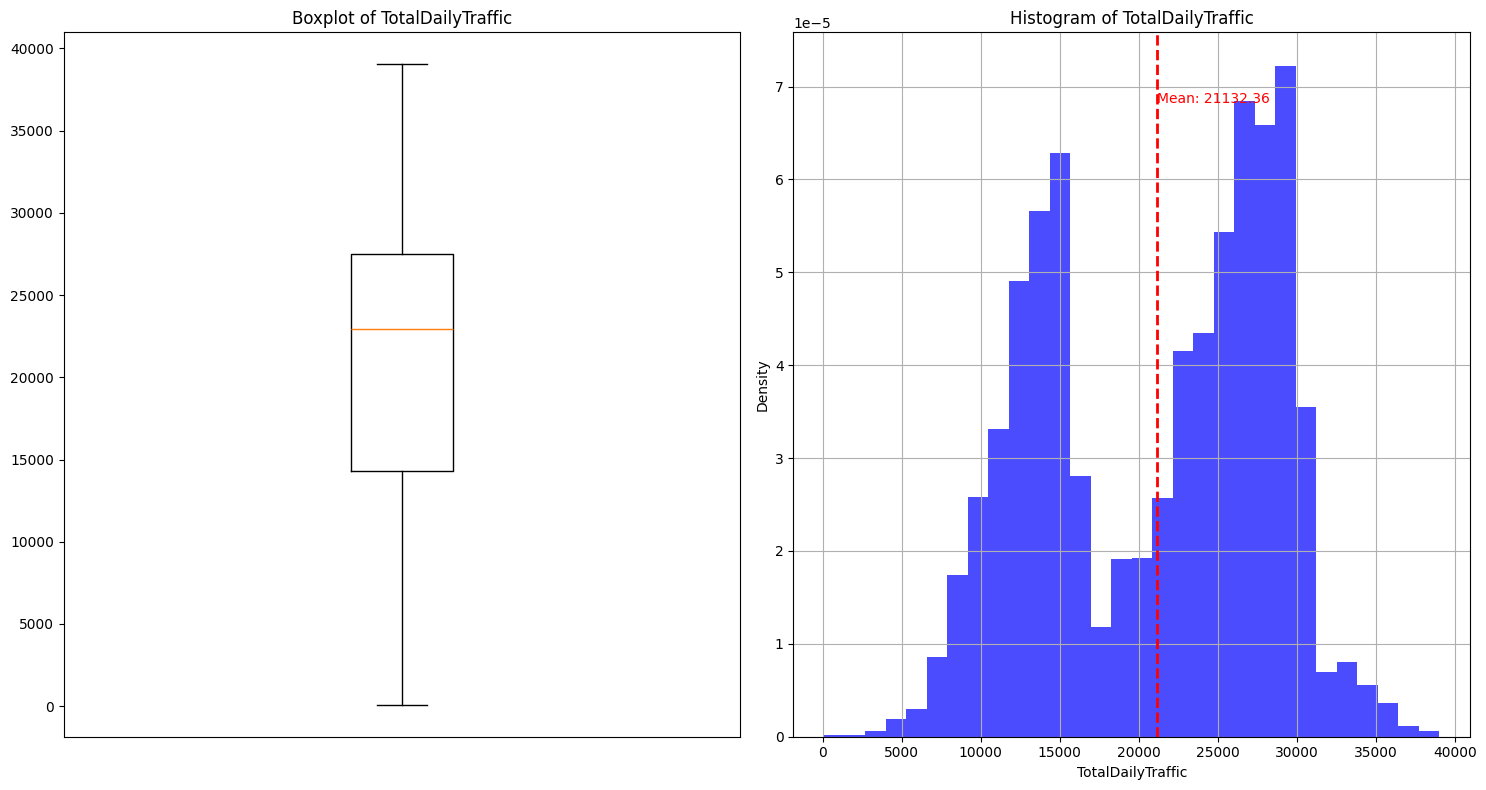

In [30]:
train_set['TotalDailyTraffic'] = train_set['TotalDailyTraffic'].replace(0, np.nan)
test_set['TotalDailyTraffic'] = test_set['TotalDailyTraffic'].replace(0, np.nan)

column_data = train_set['TotalDailyTraffic'].dropna()

# Adding a boxplot to the left of the histogram for 'TotalDailyTraffic'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# Boxplot
axes[0].boxplot(column_data)
axes[0].set_title('Boxplot of TotalDailyTraffic')
axes[0].set_xticks([])

# Histogram
axes[1].hist(column_data, bins=30, color='blue', alpha=0.7, density=True)
axes[1].set_title('Histogram of TotalDailyTraffic')
axes[1].set_xlabel('TotalDailyTraffic')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adding mean to the histogram
mu = column_data.mean()
axes[1].axvline(mu, color='red', linestyle='dashed', linewidth=2)
axes[1].text(mu, axes[1].get_ylim()[1] * 0.9, f'Mean: {mu:.2f}', color='red')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

The Total Daily Traffic is more difficult to impute, as it we have high values around the edges. We can try distinguishing Weekends (including Friday) and Weekdays

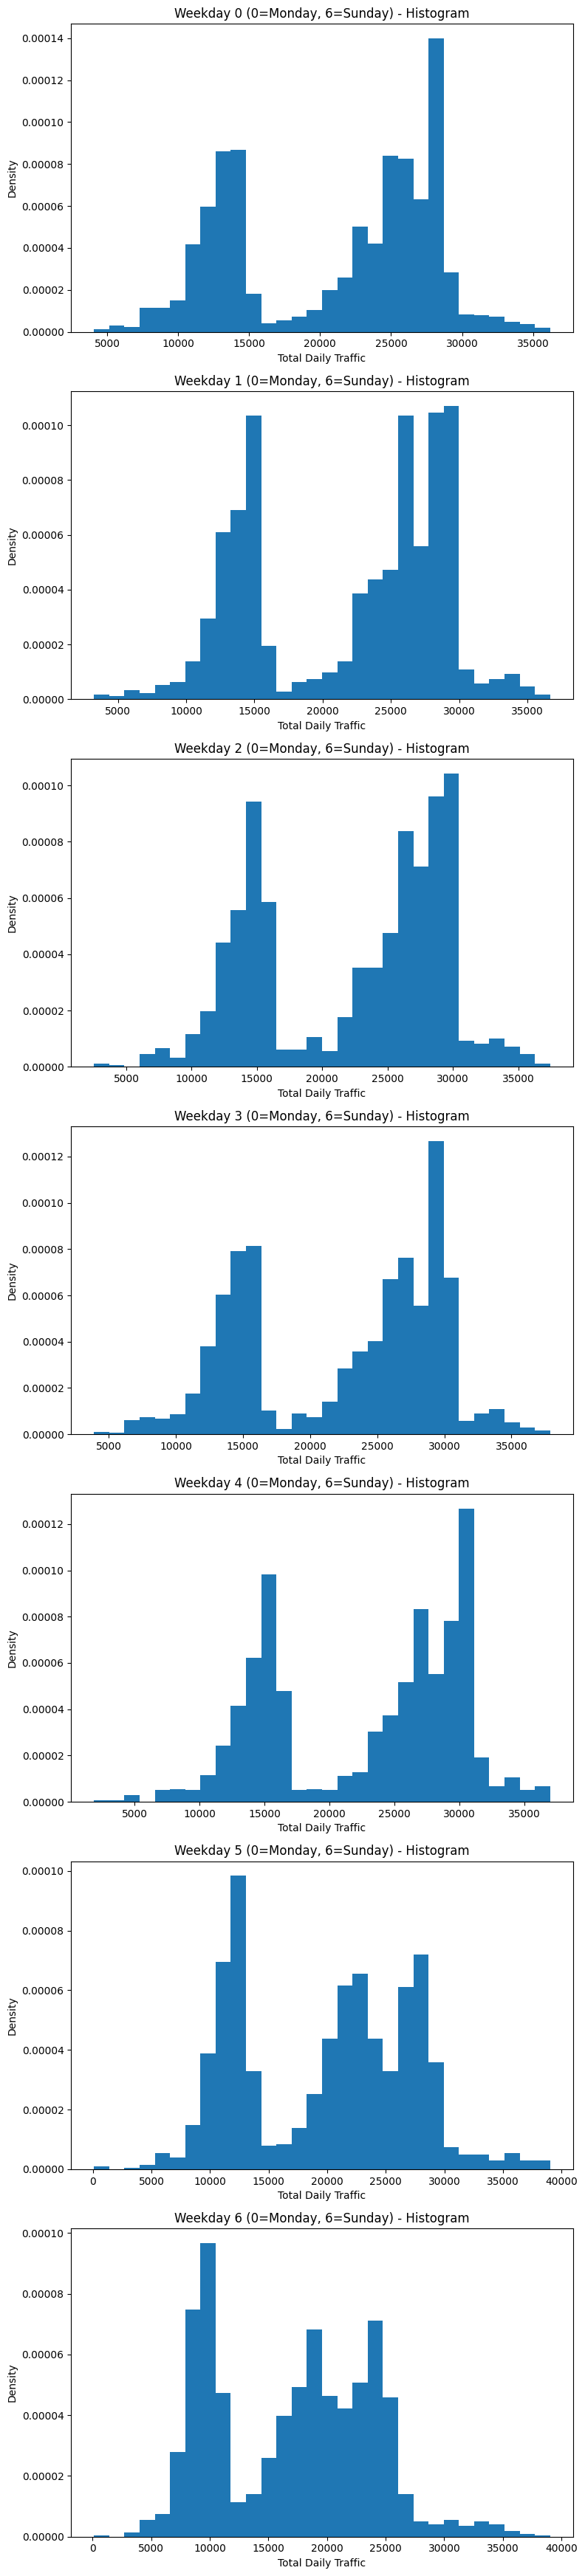

In [31]:
# Plotting distributions for each day of the week using 'Weekday_X' columns
plt.figure(figsize=(15, 35))
for i in range(7):
    
    # Filtering data for each weekday
    weekday_data = train_set[train_set[f'Weekday_{i}'] == 1]['TotalDailyTraffic']
    weekday_data = weekday_data.dropna()

    # Creating subplot for histogram 
    ax_hist = plt.subplot(7, 2, 2*i+1)
    ax_hist.hist(weekday_data, bins=30, density=True)
    ax_hist.set_title(f'Weekday {i} (0=Monday, 6=Sunday) - Histogram')
    ax_hist.set_xlabel('Total Daily Traffic')
    ax_hist.set_ylabel('Density')

plt.tight_layout()
plt.show()

We still observe the same distribution. Let's go ahead and try to work with median imputation

In [32]:
# Calculate the median of 'TotalDailyTraffic'
median_traffic_train = train_set['TotalDailyTraffic'].median()

# Replace NaN values with the median
train_set['TotalDailyTraffic'] = train_set['TotalDailyTraffic'].fillna(median_traffic_train)
test_set['TotalDailyTraffic'] = test_set['TotalDailyTraffic'].fillna(median_traffic_train)


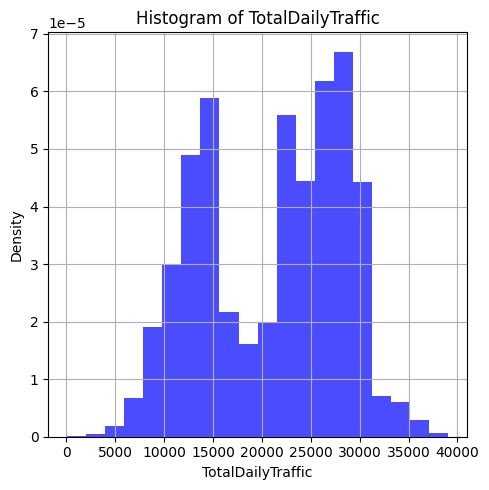

In [33]:
plt.figure(figsize=(5, 5))

column_data = train_set['TotalDailyTraffic']
plt.hist(column_data, bins=20, color='blue', alpha=0.7, density=True)
plt.title('Histogram of TotalDailyTraffic')
plt.xlabel('TotalDailyTraffic')
plt.ylabel('Density')
plt.grid(True)

# Calculate mean and standard deviation
mu = column_data.mean()
sigma = column_data.std()

# Generate a range of values
x = np.linspace(column_data.min(), column_data.max(), 100)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

we will work with that

**Filling the rest of the columns' NaN Values**

For those with small or no outliers, we will use the mean to impute. These are the following columns: "O3", "O3_max_h1", "O3_nb_h1>120", "T", "T_max_h1", "WD", "Hr"

For those with a a lot and strong outliers, we will use the median, as it is more robust to those. These are the following columns: 'NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p' ,'WVv', 'WVs'

In [34]:
# Define the columns with normal distribution and skewed distribution
columns_little_outliers = ["O3", "O3_max_h1", "O3_nb_h1>120", "T", "T_max_h1", "WD", "Hr"]
columns_many_outliers = ['NO', 'NO2', 'NOx', 'PM10', 'RainDur', 'p' ,'WVv', 'WVs']

#Impute NaNs in columns with little outliers using the mean
for col in columns_little_outliers:
    mean_value_train = train_set[col].mean()
    train_set[col] = train_set[col].fillna(mean_value_train)
    test_set[col] = test_set[col].fillna(mean_value_train)

# Impute NaNs in columns with a lot of outliers using the median
for col in columns_many_outliers:
    median_value_train = train_set[col].median()
    train_set[col] = train_set[col].fillna(median_value_train)
    test_set[col] = test_set[col].fillna(median_value_train)
# Check if there are any NaN values left in the specified columns

nan_after_imputation_train = train_set.isna().sum()
nan_after_imputation_test = test_set.isna().sum()


nan_after_imputation_train == 0, nan_after_imputation_test == 0

(index                True
 Datum                True
 TotalDailyTraffic    True
 Street               True
 NO                   True
 NO2                  True
 NOx                  True
 O3                   True
 O3_max_h1            True
 O3_nb_h1>120         True
 PM10                 True
 RainDur              True
 T                    True
 T_max_h1             True
 p                    True
 WD                   True
 WVv                  True
 WVs                  True
 Hr                   True
 Season_1             True
 Season_2             True
 Season_3             True
 Season_4             True
 Weekday_0            True
 Weekday_1            True
 Weekday_2            True
 Weekday_3            True
 Weekday_4            True
 Weekday_5            True
 Weekday_6            True
 1.5km_green          True
 1km_green            True
 500m_green           True
 200m_green           True
 1.5km_trees          True
 1km_trees            True
 500m_trees           True
 

### Feature Engineering: Reducing Multicollinearity

1. we will reduce one of the month and one of the weekday columns. This last dummy is redundant. It might help reducing multicollinearity


In [41]:
train_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)
test_set.drop(columns=['Weekday_6', 'Season_4'], inplace=True)

KeyError: "['Weekday_6', 'Season_4'] not found in axis"

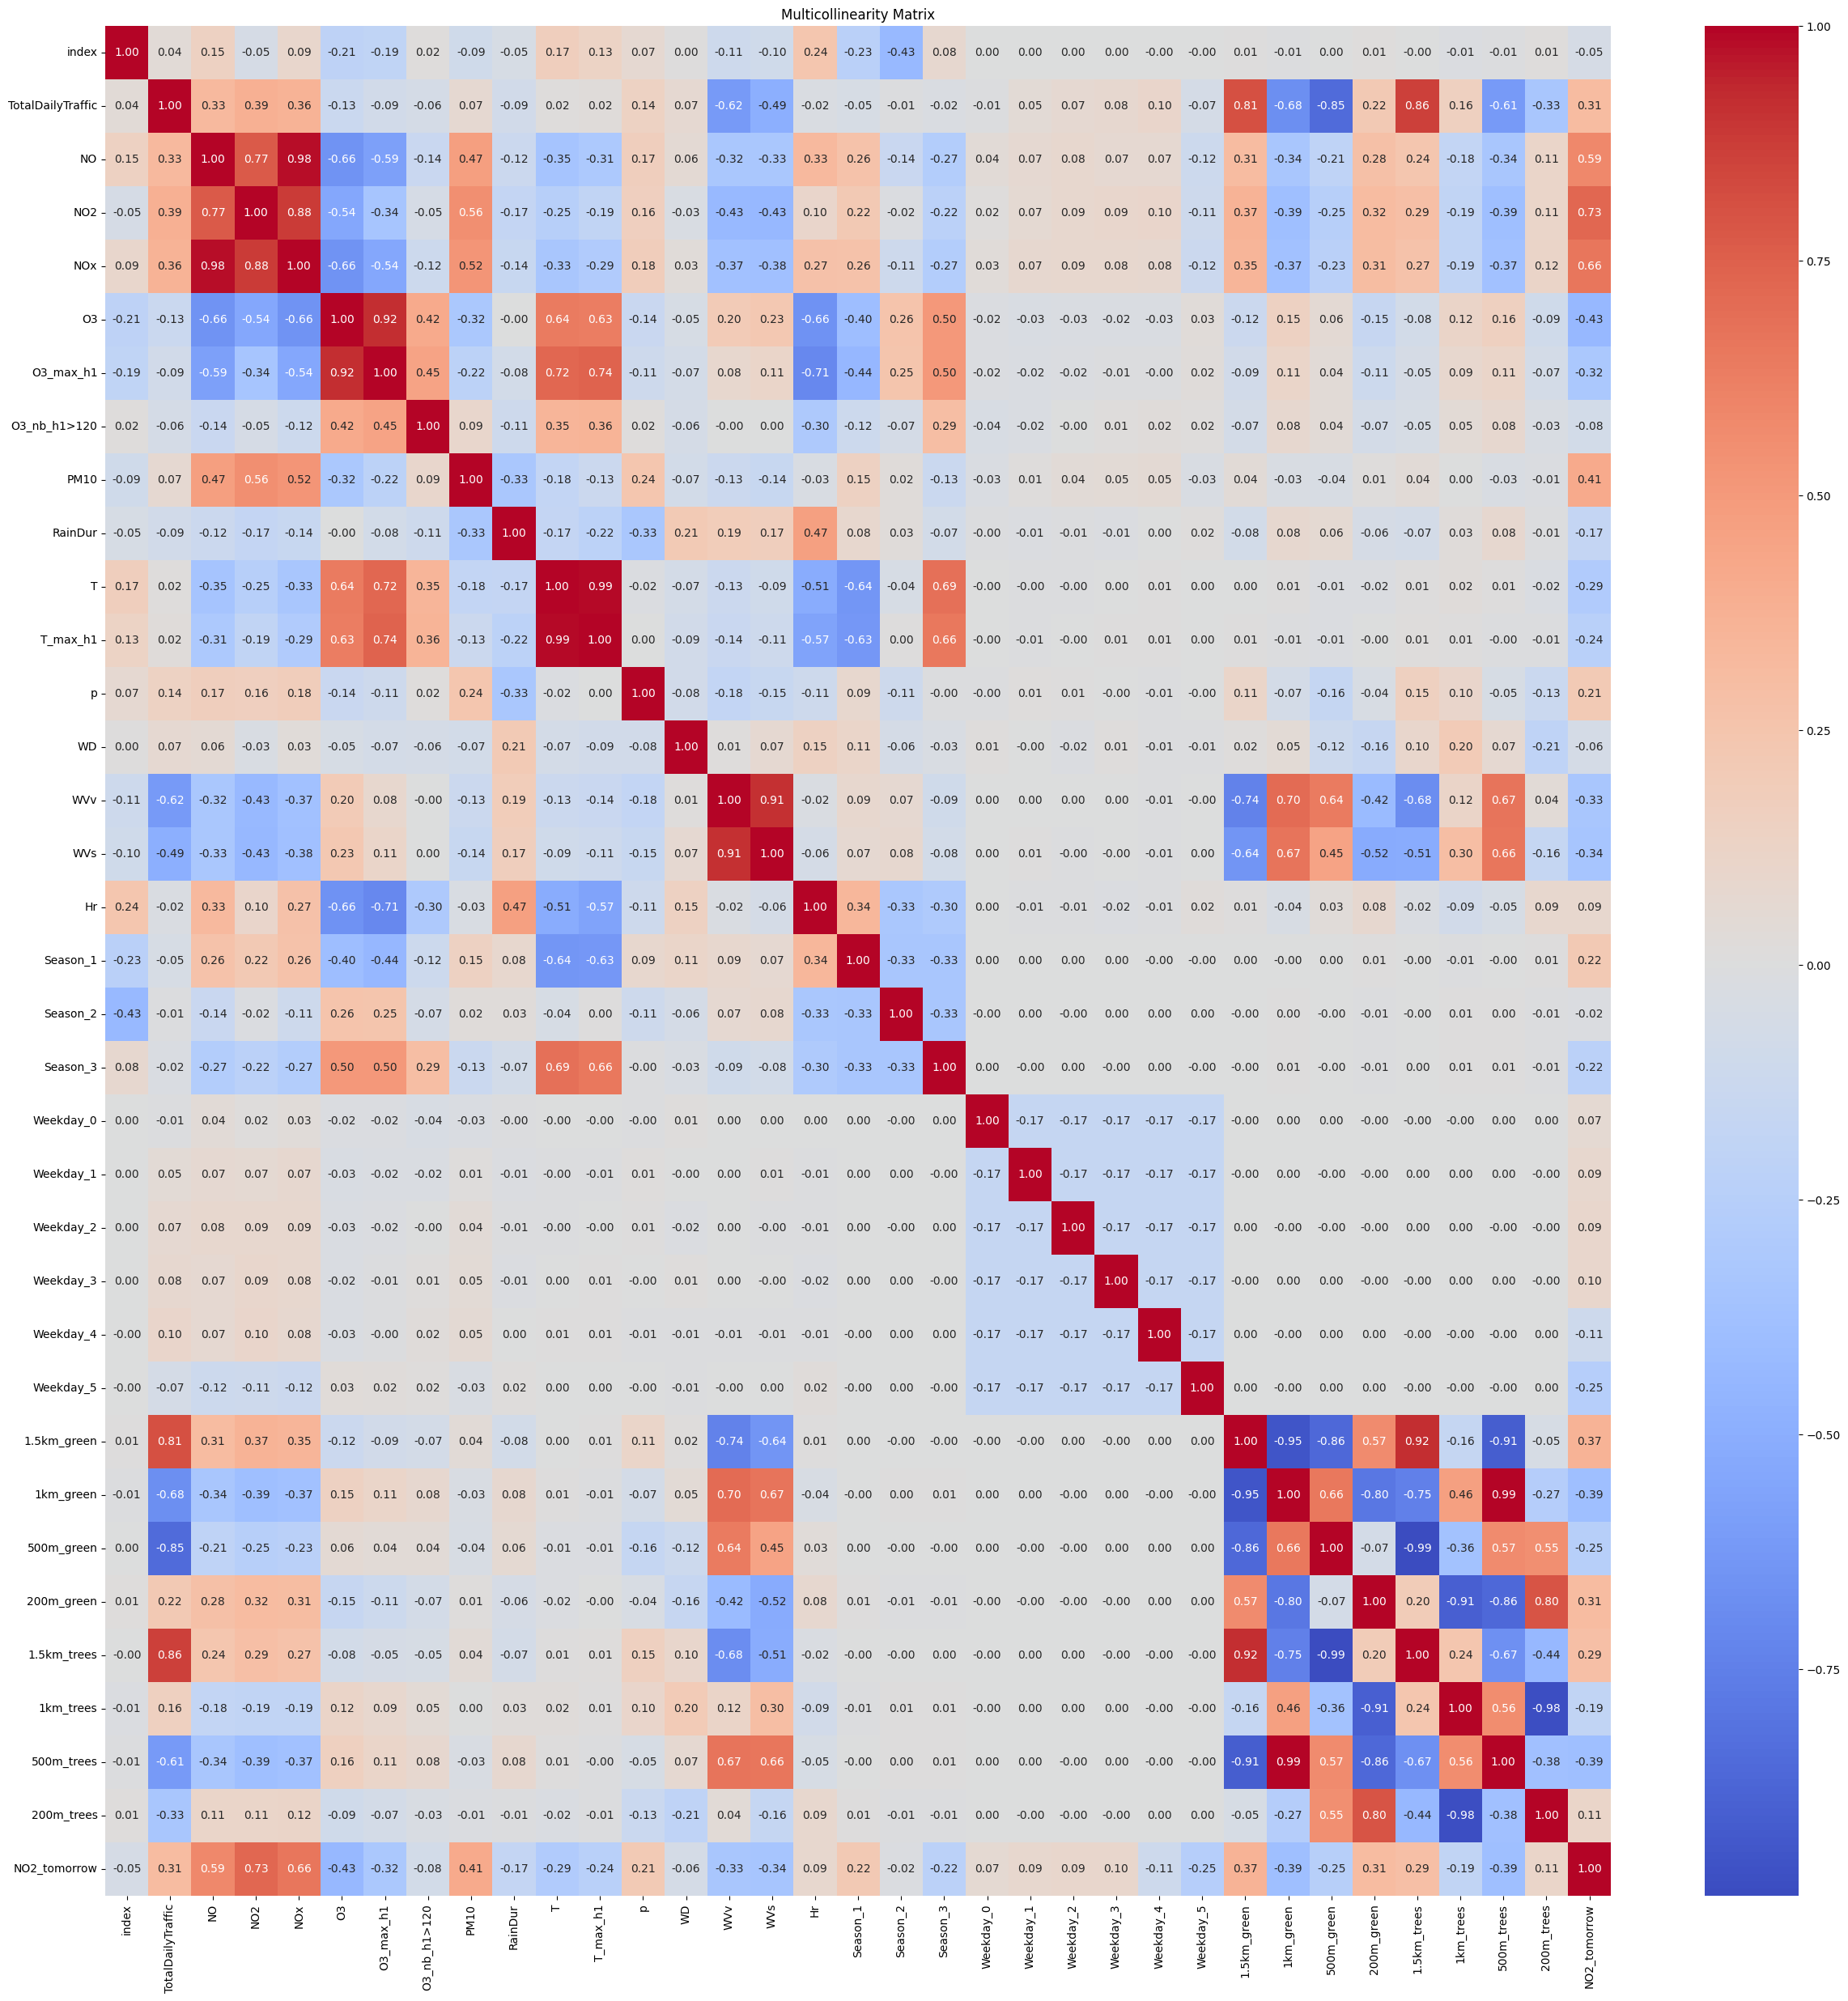

In [42]:
corr_matrix = train_set.drop(columns=['Datum', 'Street']).corr()

# Use a heatmap to visualize the correlation matrix
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Multicollinearity Matrix')
plt.show()

2. From the multicollinearity matrix we see that we have some features which are highly correlated. In order to improve the performance of our model, we will delete one of the two features, if the multicollinearity is higher than 0.8

In [43]:
high_corr_var = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            colname = corr_matrix.columns[i]
            high_corr_var.add(colname)

# Remove the identified features
train_reduced = train_set.drop(columns=high_corr_var)
test_reduced = test_set.drop(columns=high_corr_var)

### Feature Engineering: Polynomials

We build some polynomial features to capture possible, non linear relationships

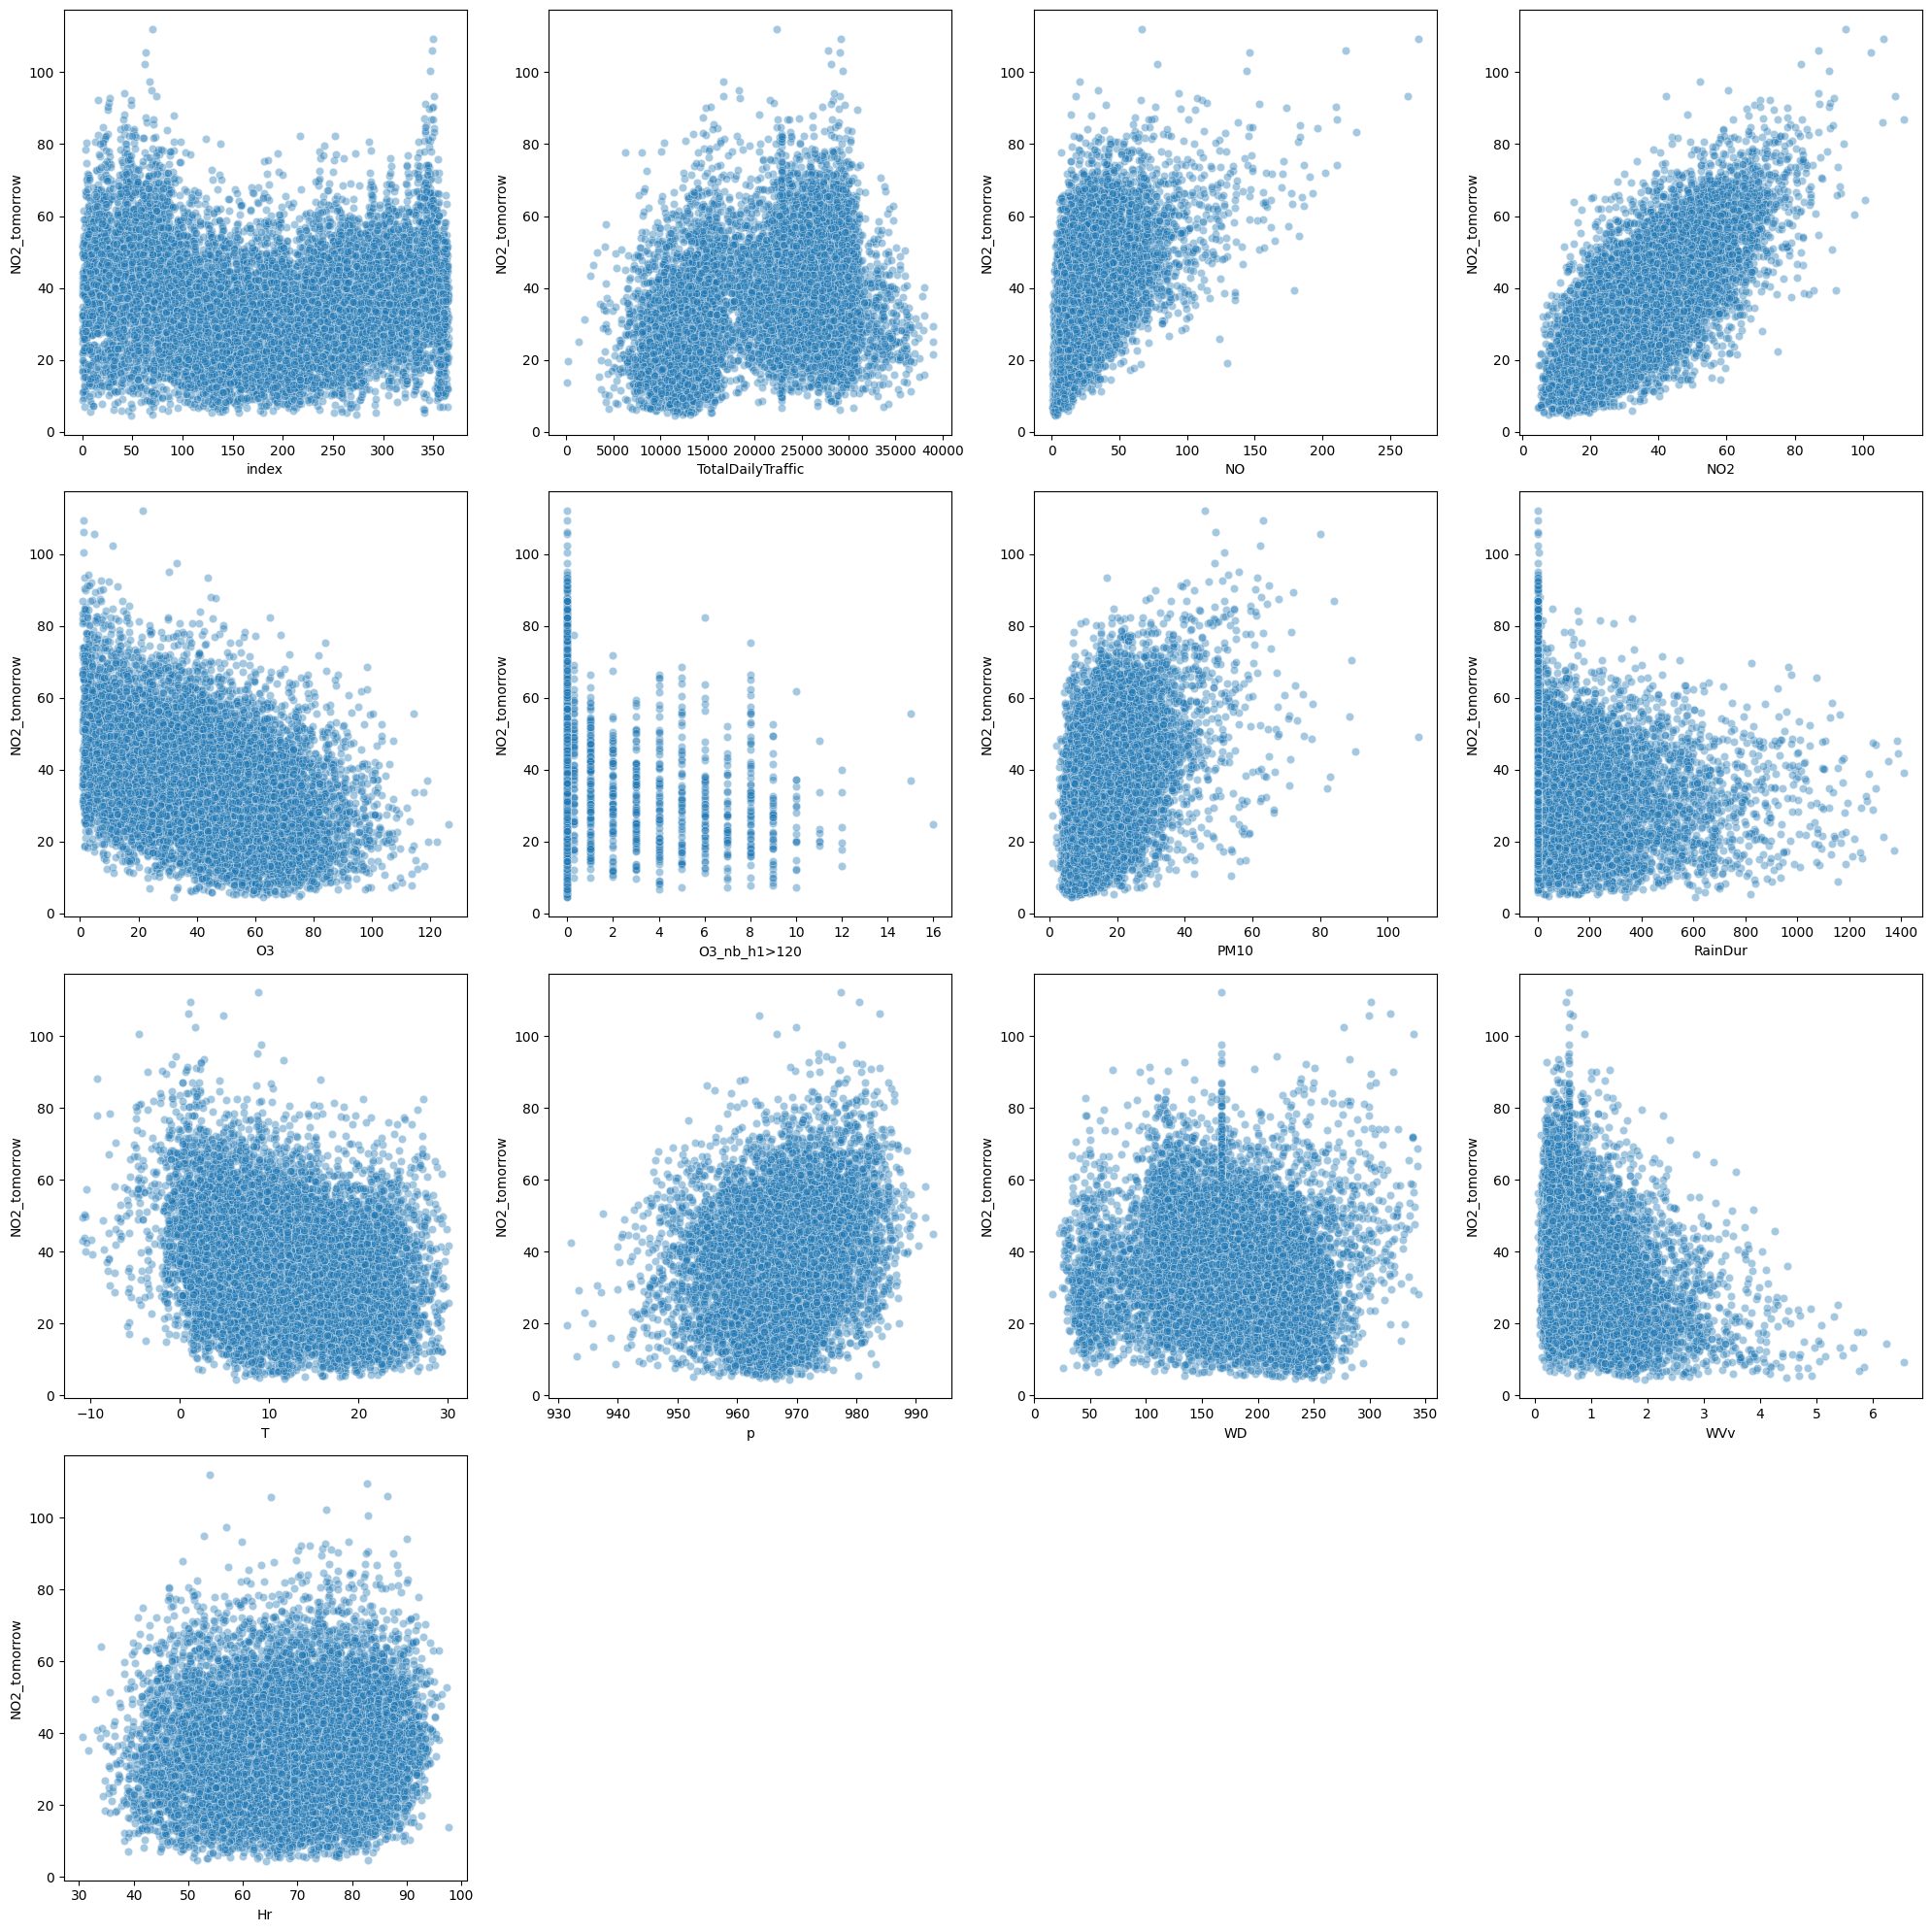

In [44]:
#plot features to see the relationships

# Selecting a subset of columns for plotting
# Excluding non-numerical columns and the target variable itself
plot_columns = train_reduced.select_dtypes(include=['float64', 'int64']).columns.drop(['NO2_tomorrow'])

# Define the number of plots: 4 columns in each row
num_columns = 4
num_rows = len(plot_columns) // num_columns + (1 if len(plot_columns) % num_columns else 0)

# Create a figure with subplots
plt.figure(figsize=(20, 5 * num_rows))

# Plotting each feature against 'NO2_tomorrow'
for i, column in enumerate(plot_columns, 1):
    plt.subplot(num_rows, num_columns, i)
    sns.scatterplot(x=train_reduced[column], y=train_reduced['NO2_tomorrow'], alpha=0.4)
    plt.xlabel(column)
    plt.ylabel('NO2_tomorrow')

plt.tight_layout()
plt.show()


we observe no clear linear relationships for most of the features. only for NO2. hence polynomials might help

In [45]:
from sklearn.preprocessing import PolynomialFeatures

def create_complete_polynomial_features(train_set, test_set, exclude_features, polydegree):
   
    # Selecting numerical features excluding the specified ones
    numerical_features = train_set.select_dtypes(include=['float64', 'int64']).columns
    selected_features = numerical_features.drop(exclude_features)

    # Extracting the selected features from the datasets
    X_train = train_set[selected_features]
    X_test = test_set[selected_features]

    # Creating polynomial features up to the specified degree
    poly = PolynomialFeatures(degree=polydegree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)  # Using the same fit for the test set

    # Creating DataFrames for the polynomial features
    poly_feature_names = poly.get_feature_names_out(selected_features)
    X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=train_set.index)
    X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=test_set.index)

    # Merging the polynomial features with the original dataset
    # This includes both the numerical features that were not included in the polynomial expansion and any non-numerical features
    train_final = pd.concat([train_set.drop(selected_features, axis=1), X_train_poly_df], axis=1)
    test_final = pd.concat([test_set.drop(selected_features, axis=1), X_test_poly_df], axis=1)

    return train_final, test_final



train_reduced_poly_2, test_reduced_poly_2 = create_complete_polynomial_features(train_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 2)
train_poly_2, test_poly_2 = create_complete_polynomial_features(train_set, test_set, ['NO2', 'NO2_tomorrow'], 2)
train_reduced_poly_3, test_reduced_poly_3 = create_complete_polynomial_features(train_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 3)
train_poly_3, test_poly_3 = create_complete_polynomial_features(train_set, test_set, ['NO2', 'NO2_tomorrow'], 3)
train_reduced_poly_4, test_reduced_poly_4 = create_complete_polynomial_features(train_reduced, test_reduced, ['NO2', 'NO2_tomorrow'], 4)
train_poly_4, test_poly_4 = create_complete_polynomial_features(train_set, test_set, ['NO2', 'NO2_tomorrow'], 4)

In [47]:
#train_set.to_csv('data/finaldata/train_set.csv')
#test_set.to_csv('data/finaldata/test_set.csv')
#train_reduced.to_csv('data/finaldata/train_reduced.csv')
#test_reduced.to_csv('data/finaldata/test_reduced.csv')

'''datasets = [
    (train_set, 'train_set'),
    (test_set, 'test_set'),
    (train_reduced, 'train_reduced'),
    (test_reduced, 'test_reduced'),
    (train_reduced_poly_2, 'train_reduced_poly_2'), (test_reduced_poly_2, 'test_reduced_poly_2'),
    (train_poly_2, 'train_poly_2'), (test_poly_2, 'test_poly_2'),
    (train_reduced_poly_3, 'train_reduced_poly_3'), (test_reduced_poly_3, 'test_reduced_poly_3'),
    (train_poly_3, 'train_poly_3'), (test_poly_3, 'test_poly_3'),
    (train_reduced_poly_4, 'train_reduced_poly_4'), (test_reduced_poly_4, 'test_reduced_poly_4'),
    (train_poly_4, 'train_poly_4'), (test_poly_4, 'test_poly_4')
]

for dataset, name in datasets:
    dataset.to_csv(f'data/finaldata/{name}.csv')'''





## Model Testing
<span style="color:red">[TO BE ADDED FROM "testmodel.ipynb"]</span>

## Linear Regression 

In [53]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Define your dataset pairs
dataset_pairs = [
    ('train_set', train_set, 'test_set', test_set),
    ('train_reduced', train_reduced, 'test_reduced', test_reduced),
    ('train_poly_2', train_poly_2, 'test_poly_2', test_poly_2),
    ('train_reduced_poly_2', train_reduced_poly_2, 'test_reduced_poly_2', test_reduced_poly_2),
    ('train_poly_3', train_poly_3, 'test_poly_3', test_poly_3),
    ('train_reduced_poly_3', train_reduced_poly_3, 'test_reduced_poly_3', test_reduced_poly_3),
    ('train_poly_4', train_poly_4, 'test_poly_4', test_poly_4),
    ('train_reduced_poly_4', train_reduced_poly_4, 'test_reduced_poly_4', test_reduced_poly_4)
]

for train_dataset_name, train_dataset, test_dataset_name, test_dataset in dataset_pairs:
    
    # Preprocess training data
    X_train = train_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_train = train_dataset['NO2_tomorrow']

    X_test = test_dataset.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
    y_test = test_dataset['NO2_tomorrow']

    # Split the training data into training and validation sets
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Standardization
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)

    # Lasso for feature selection
    lasso = LassoCV(cv=5, random_state=0, max_iter=100000, tol=0.01).fit(X_train_scaled, y_train_split)
    important_features = lasso.coef_ != 0
    X_train_important = X_train_scaled[:, important_features]
    X_val_important = X_val_scaled[:, important_features]

    # Ridge regression on selected features
    ridge = RidgeCV(alphas=[0.1, 1.0, 10.0]).fit(X_train_important, y_train_split)

    # Evaluate on validation set
    y_pred_val = ridge.predict(X_val_important)
    mse_val = mean_squared_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)

    print(f"Dataset Pair: {train_dataset_name}")
    print(f"Validation MSE: {mse_val}, Validation R2 Score: {r2_val}")
    print(f"Selected Ridge Alpha: {ridge.alpha_}\n")

    # Code for final evaluation on the test set is provided but should be used only after finalizing the model
    X_test_scaled = scaler.transform(X_test)
    X_test_important = X_test_scaled[:, important_features]
    y_pred_test = ridge.predict(X_test_important)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)
    print(f"Dataset Pair: {train_dataset_name} / {test_dataset_name} - Test Set")
    print(f"Test MSE: {mse_test}, Test R2 Score: {r2_test}\n")


Dataset Pair: train_set
Validation MSE: 78.00679666230751, Validation R2 Score: 0.6764866303130854
Selected Ridge Alpha: 0.1

Dataset Pair: train_set / test_set - Test Set
Test MSE: 53.387283962860685, Test R2 Score: 0.5425927759056012

Dataset Pair: train_reduced
Validation MSE: 78.6627605636768, Validation R2 Score: 0.673766186695286
Selected Ridge Alpha: 0.1

Dataset Pair: train_reduced / test_reduced - Test Set
Test MSE: 56.619696795549345, Test R2 Score: 0.5148983724600956

Dataset Pair: train_poly_2
Validation MSE: 74.87510850369054, Validation R2 Score: 0.6894745112715703
Selected Ridge Alpha: 0.1

Dataset Pair: train_poly_2 / test_poly_2 - Test Set
Test MSE: 52.235260594478554, Test R2 Score: 0.5524629879094582

Dataset Pair: train_reduced_poly_2
Validation MSE: 76.47731836552114, Validation R2 Score: 0.6828297529489037
Selected Ridge Alpha: 1.0

Dataset Pair: train_reduced_poly_2 / test_reduced_poly_2 - Test Set
Test MSE: 55.92758184199982, Test R2 Score: 0.5208282185986919

D

KeyboardInterrupt: 

### Random Forest

Here it makes no difference whether we use polynomials or not. so we will just use our regular train set

In [54]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dropping non-numeric and irrelevant columns
X_train = train_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_train = train_set['NO2_tomorrow']

X_test = test_set.drop(columns=['Datum', 'Street', 'NO2_tomorrow'])
y_test = test_set['NO2_tomorrow']

# Split the training data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Building the Random Forest Regressor with Cross-Validation to optimize hyperparameters
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_split, y_train_split)

# Best parameters
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Evaluating the optimized model on the validation set
y_pred_val = best_rf.predict(X_val)
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

print(f"Train MSE: {mse_val}, Train R2 Score: {r2_val}, Best Parameters: {best_params}")

#evaluate it on our test set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test Set")
print(f"Test MSE: {mse_test}, Test R2 Score: {r2_test}\n")



Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  16.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  17.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  34.5s
[CV] END max_de